In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from datetime import timedelta

from IPython.display import display, Markdown, Latex

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('notebook')

from glob import glob
from os import path
import os
from multiprocessing import Pool

import vg

from collections import defaultdict, namedtuple

import sqlite3

import sys
sys.path.insert(1, '../src/')
from mythicwind.gps import *
from mythicwind.csv_io import *
from mythicwind.tools import printMD, printTeX

data_dir = '../data'
turbine_data_dir = '../data/turbines/'
results_dir = '../results'

# selected_turbines = [f'turbine-{i:02d}' for i in range(4, 17)]
selected_turbines = [f'turbine-{i:02d}' for i in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def find_installation_times(turbine_dataset, sbi_altitude_limit=90, buffer_timedelta=pd.to_timedelta('30min'), resample_period='1s', smoothing_period='20min', selection_threshold=pd.to_timedelta('60s')):

    sbi_times = list() # used to store pairs of single blade installation start/stop datetimes
    
    hh, sr, st = (turbine_dataset.helihoist.altitude.resample(resample_period).mean().rolling(smoothing_period).mean(), 
                  turbine_dataset.sbitroot.altitude.resample(resample_period).mean().rolling(smoothing_period).mean(), 
                  turbine_dataset.sbittip.altitude.resample(resample_period).mean().rolling(smoothing_period).mean(),
                 )

    hammerhead_start = hh[hh > sbi_altitude_limit].index[0] + buffer_timedelta

    hh_sbi = hh[(hh > sbi_altitude_limit) & (sr > sbi_altitude_limit) & (st > sbi_altitude_limit)]
    
    if len(hh_sbi) == 0:
        print(f'failed to identify sbi times')
        print(f'trying only with sbitroot')
        hh_sbi = hh[(hh > sbi_altitude_limit) & (sr > sbi_altitude_limit)]
        
        if len(hh_sbi) == 0:
            print(f'failed to identify sbi times only using sbitroot')
            print(f'trying only with sbittip')
            hh_sbi = hh[(hh > sbi_altitude_limit) & (st > sbi_altitude_limit)]
            
            if len(hh_sbi) == 0:
                print(f'failed to identify sbit times only using sbittip')
                print(f'stopping')
                raise Exception('failed to identify blade landings')
    
    ii = hh_sbi[hh_sbi.index.to_series().diff() > selection_threshold].index.to_list()
    
    ii.insert(0, hh_sbi.index[0])
    ii.insert(len(ii), hh_sbi.index[-1])    

    for i in range(len(ii) - 1):
        sbi_times.append((ii[i] - pd.to_timedelta(smoothing_period)/2, hh_sbi[ii[i]:ii[i+1]].index[-2] - pd.to_timedelta(smoothing_period)/2 ))
    
    return sbi_times


def find_hammerhead_times(turbine_dataset, first_sbi=None, altitude_limit=90, buffer_timedelta=pd.to_timedelta('30min'), resample_period='1s', smoothing_period='20min'):
    
    if not first_sbi:
        try:
            sbi_times = find_installation_times(turbine_dataset, sbi_altitude_limit=altitude_limit, buffer_timedelta=buffer_timedelta, resample_period=resample_period, smoothing_period=smoothing_period)
            print(f'found first sbi: {sbi_times[0][0]}')
        except:
            raise Exception(f'failed to identify blade landings, please provide manual blade landing datetime')   
        
        first_sbi = sbi_times[0][0]

    hh = turbine_dataset.helihoist.altitude.resample(resample_period).mean().rolling(smoothing_period).mean()    
    
    hammerhead_start = hh[hh > altitude_limit].index[0] + buffer_timedelta
    
    return(hammerhead_start, first_sbi)
    
    
def plot_sbi_times(turbine_dataset, sbi_times, blade_landings):
    plt.figure()    

    plt.plot(turbine_dataset.helihoist.altitude, alpha=0.25, label='helihoist', color='tab:blue')
    plt.plot(turbine_dataset.sbitroot.altitude, alpha=0.25, label='sbitroot', color='tab:orange')
    plt.plot(turbine_dataset.sbittip.altitude, alpha=0.25, label='sbittip', color='tab:green')

    if not sbi_times:
        return
    
    for (start, end) in sbi_times:
        plt.plot(turbine_dataset.helihoist[start:end].altitude, color='tab:blue')
        plt.plot(turbine_dataset.sbitroot[start:end].altitude, color='tab:orange')
        plt.plot(turbine_dataset.sbittip[start:end].altitude, color='tab:green')
    
        for blade_landing_i, blade_landing in enumerate(blade_landings):
            print(blade_landing_i)
            plt.axvspan(xmin=start, xmax=end, hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
            if blade_landing > start and blade_landing < end:
                plt.axvline(x=blade_landing, color='tab:purple', linewidth=2, label=f'successfull blade landing {blade_landing_i}')
                if blade_landing_i == 0:
                    print(f'first successful blade landing')
                    hammerhead_end = blade_landing - pd.to_timedelta('30min')
                    plt.axvspan(xmin=hammerhead_start, xmax=hammerhead_end, label='hammerhead configuration', facecolor='white', alpha=0.25, edgecolor='tab:green', hatch='//')
    plt.tight_layout()
    plt.ylabel('altitude (m)')
    plt.legend(loc='upper left')
    plt.show()

## Installation times from time-tracking

In [4]:
blade_installations = defaultdict(list)
blade_landings = defaultdict(dict)
TNHBx = defaultdict(list)
hammerheads = dict()

install_db = sqlite3.connect(path.join(data_dir, 'installation_times/installation_times.sqlite'))
install_db_cur = install_db.cursor()

for (turbine_name, blade_number, start_epoch, end_epoch) in install_db_cur.execute('SELECT turbine_name, blade_number, blade_installation_start_epoch, blade_installation_end_epoch FROM blade_installation_success WHERE turbine_id < 17'):
    start = pd.to_datetime(start_epoch, unit='s', utc=True)
    end = pd.to_datetime(end_epoch, unit='s', utc=True)
    delta_t = end-start

    blade_installations[turbine_name].append((start, end))
    
for (turbine_name, blade_number, blade_landing) in install_db_cur.execute('SELECT turbine_name, blade_number, blade_landing_epoch FROM blade_landings_full'):
    blade_landings[turbine_name][blade_number] = pd.to_datetime(blade_landing, unit='s', utc=True)

for turbine_name, installation in blade_installations.items():
    print(f'{turbine_name} TNHB1: {blade_installations[turbine_name][0][1]} -> {blade_installations[turbine_name][1][0]}')
    TNHBx[turbine_name].append((blade_installations[turbine_name][0][1], blade_installations[turbine_name][1][0]))
    
    print(f'{turbine_name} TNHB2: {blade_installations[turbine_name][1][1]} -> {blade_installations[turbine_name][2][0]}')
    TNHBx[turbine_name].append((blade_installations[turbine_name][1][1], blade_installations[turbine_name][2][0]))

turbine-01 TNHB1: 2019-08-05 10:00:00+00:00 -> 2019-08-09 04:30:00+00:00
turbine-01 TNHB2: 2019-08-09 08:00:00+00:00 -> 2019-08-12 23:00:00+00:00
turbine-02 TNHB1: 2019-08-21 23:30:00+00:00 -> 2019-08-23 11:00:00+00:00
turbine-02 TNHB2: 2019-08-23 13:30:00+00:00 -> 2019-08-23 16:00:00+00:00
turbine-03 TNHB1: 2019-08-26 00:00:00+00:00 -> 2019-08-26 03:15:00+00:00
turbine-03 TNHB2: 2019-08-26 10:00:00+00:00 -> 2019-08-26 13:15:00+00:00
turbine-04 TNHB1: 2019-09-07 12:30:00+00:00 -> 2019-09-08 04:30:00+00:00
turbine-04 TNHB2: 2019-09-08 21:35:00+00:00 -> 2019-09-09 03:00:00+00:00
turbine-05 TNHB1: 2019-09-20 07:17:00+00:00 -> 2019-09-20 11:47:00+00:00
turbine-05 TNHB2: 2019-09-20 12:50:00+00:00 -> 2019-09-20 16:10:00+00:00
turbine-06 TNHB1: 2019-09-22 12:23:00+00:00 -> 2019-09-22 21:53:00+00:00
turbine-06 TNHB2: 2019-09-23 00:10:00+00:00 -> 2019-09-23 11:15:00+00:00
turbine-07 TNHB1: 2019-09-25 13:45:00+00:00 -> 2019-09-25 18:00:00+00:00
turbine-07 TNHB2: 2019-09-25 21:00:00+00:00 -> 2019

## Installation times from GNSS

In [5]:
GNSS_dataset = namedtuple('GNSS_dataset', ['helihoist', 'sbitroot', 'sbittip'])

turbines = dict()

for turbine_path in sorted(glob(path.join(turbine_data_dir, f'turbine-??'))):
    
    turbine_id = turbine_path.split('/')[3]
   
    if turbine_id not in selected_turbines:
        print(f'skipping {turbine_id}')
        continue

    print(f'processing {turbine_id}')
        
    gnss_data_temp = {'helihoist-1' : None,
                      'sbitroot'  : None,
                      'sbittip'   : None,
                     }
    
    for pos in ('helihoist-1', 'sbitroot', 'sbittip'):
        
        print(f'processing {turbine_id}/{pos}')
        
        gps_file_path = path.join(path.join(turbine_path, pos), f'tom/gps/{turbine_id}_{pos}_tom_gps.csv')
        
        if path.isfile(gps_file_path):
                        
            gnss_data_temp[pos] = read_frame(gps_file_path)
    
    turbines[turbine_id] = GNSS_dataset(gnss_data_temp['helihoist-1'], gnss_data_temp['sbitroot'], gnss_data_temp['sbittip'])
    
    

skipping turbine-01
skipping turbine-02
skipping turbine-03
processing turbine-04
processing turbine-04/helihoist-1
processing turbine-04/sbitroot
processing turbine-04/sbittip
processing turbine-05
processing turbine-05/helihoist-1
processing turbine-05/sbitroot
processing turbine-05/sbittip
processing turbine-06
processing turbine-06/helihoist-1
processing turbine-06/sbitroot
processing turbine-06/sbittip
processing turbine-07
processing turbine-07/helihoist-1
processing turbine-07/sbitroot
processing turbine-07/sbittip
processing turbine-08
processing turbine-08/helihoist-1
processing turbine-08/sbitroot
processing turbine-08/sbittip
processing turbine-09
processing turbine-09/helihoist-1
processing turbine-09/sbitroot
processing turbine-09/sbittip
processing turbine-10
processing turbine-10/helihoist-1
processing turbine-10/sbitroot
processing turbine-10/sbittip
processing turbine-11
processing turbine-11/helihoist-1
processing turbine-11/sbitroot
processing turbine-11/sbittip
proc

4 turbine-04


<IPython.core.display.Javascript object>


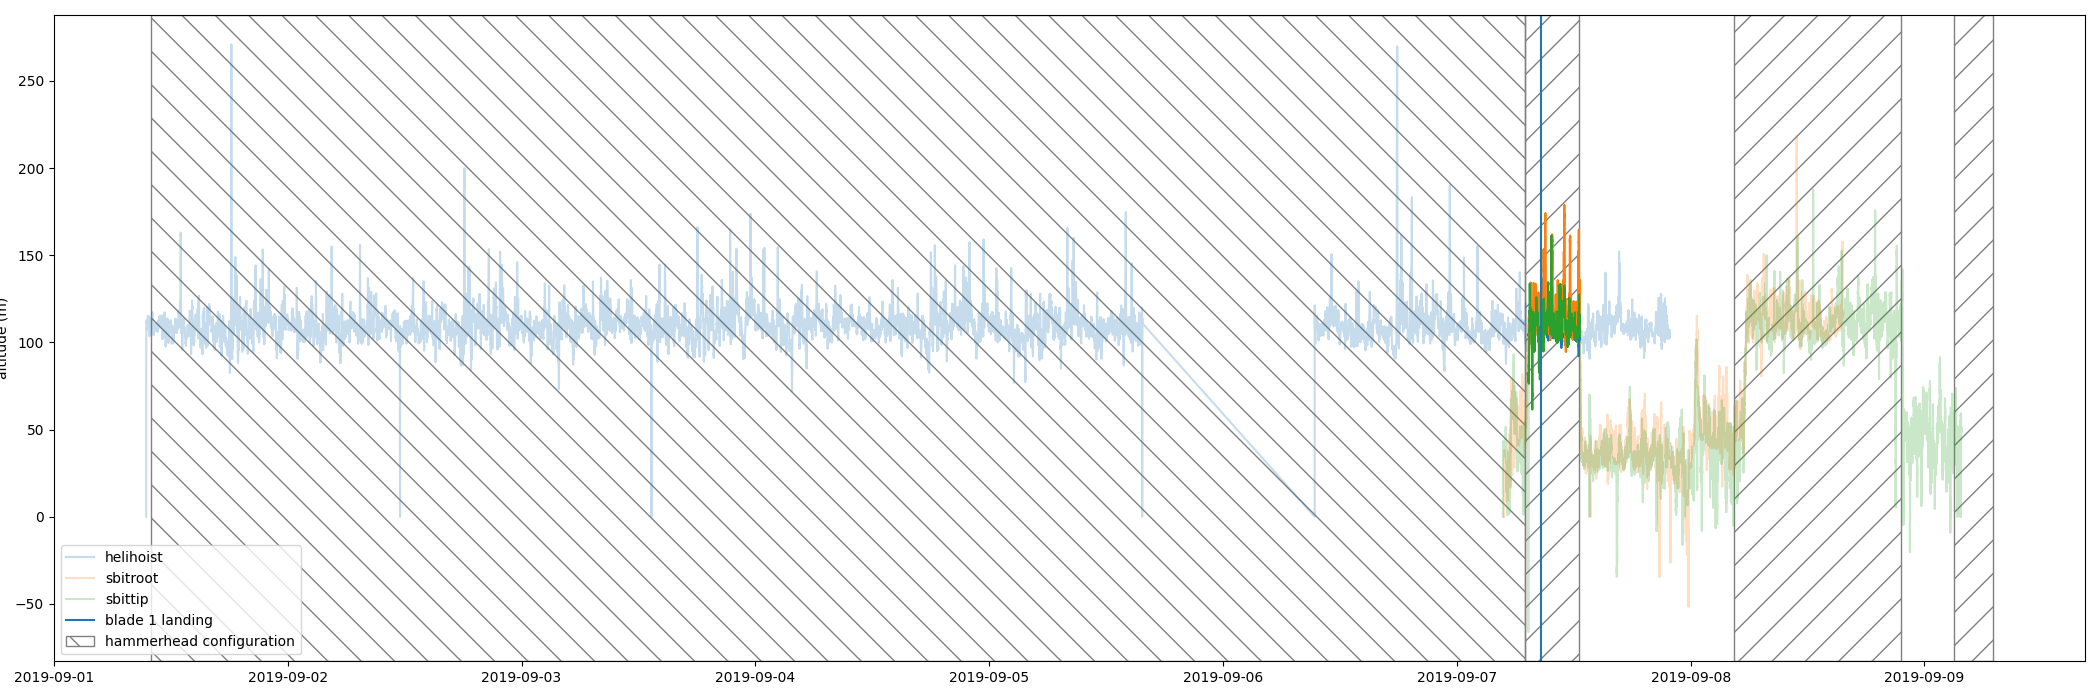

5 turbine-05


<IPython.core.display.Javascript object>


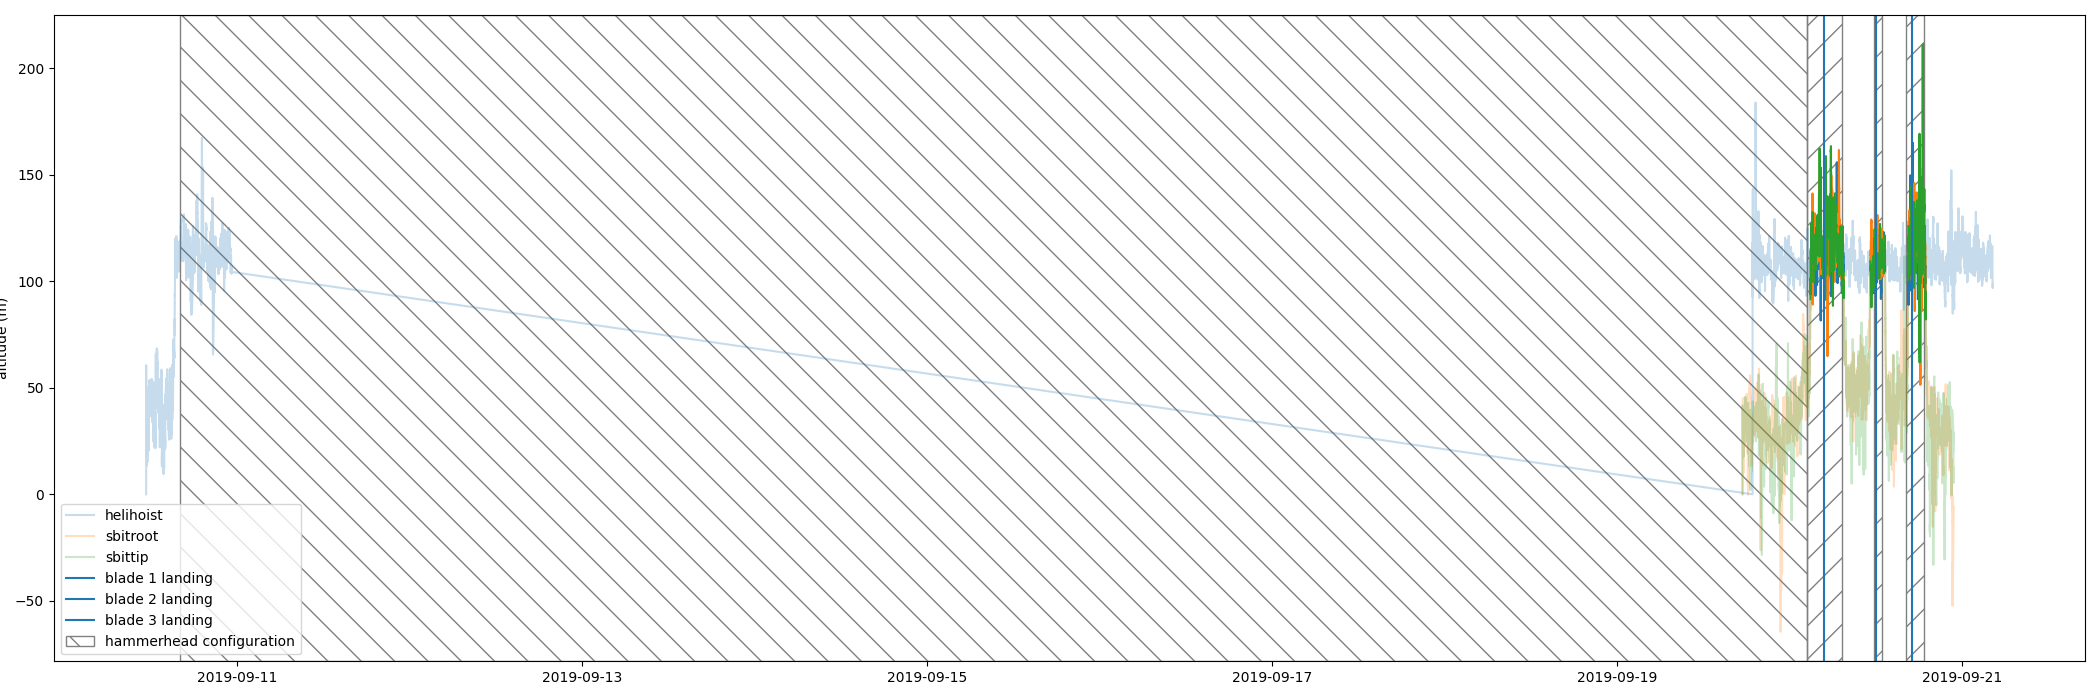

6 turbine-06


<IPython.core.display.Javascript object>


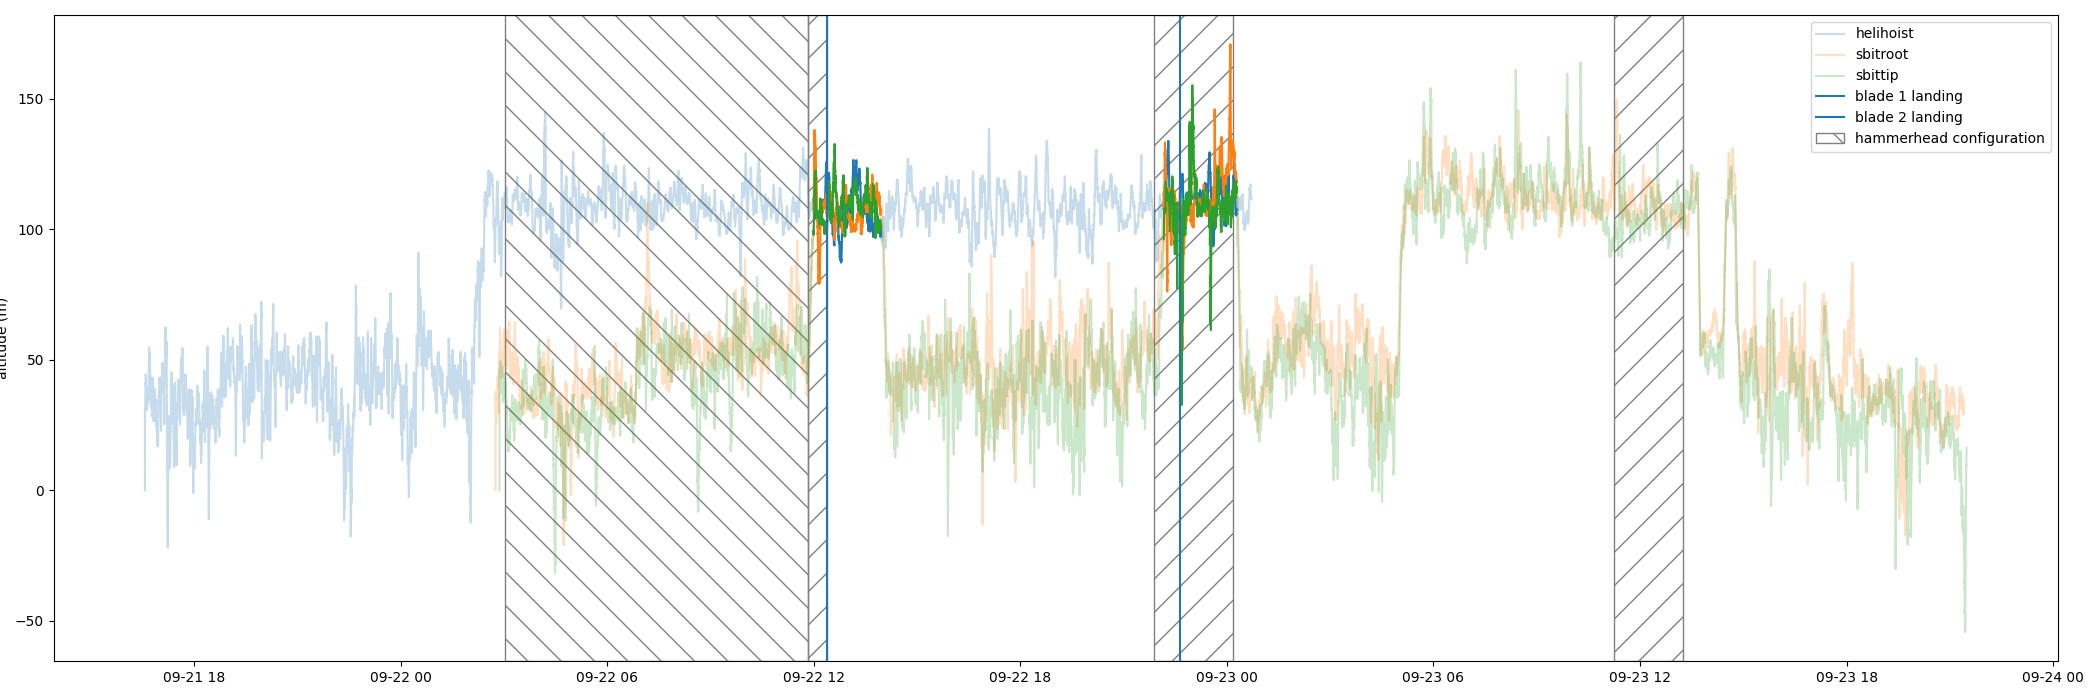

7 turbine-07
failed to identify sbi times
trying only with sbitroot


<IPython.core.display.Javascript object>


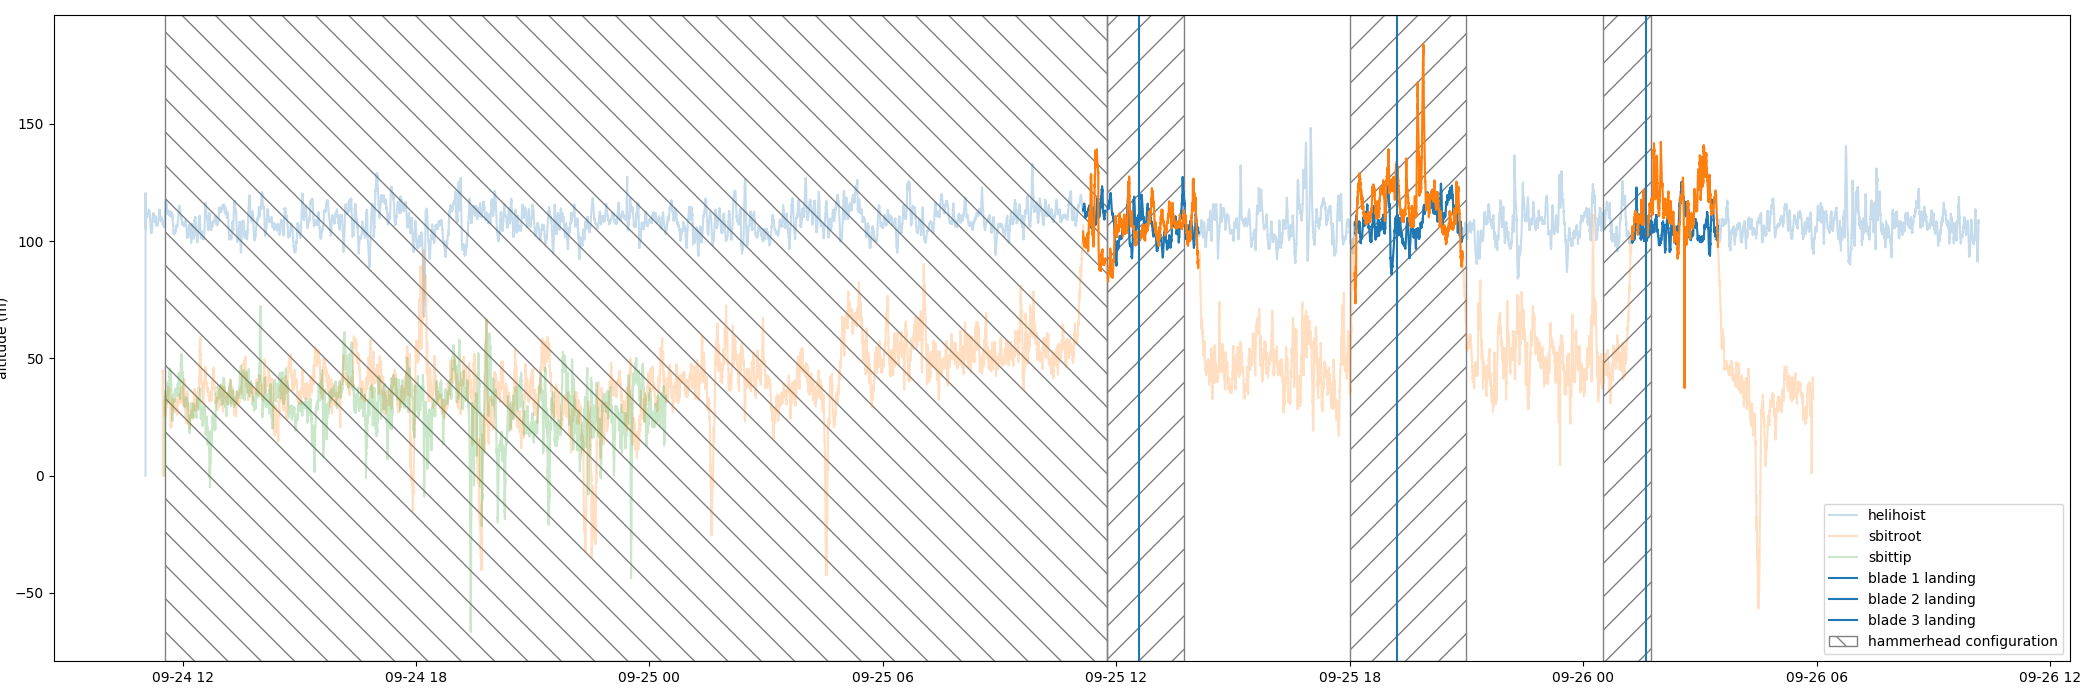

8 turbine-08


<IPython.core.display.Javascript object>


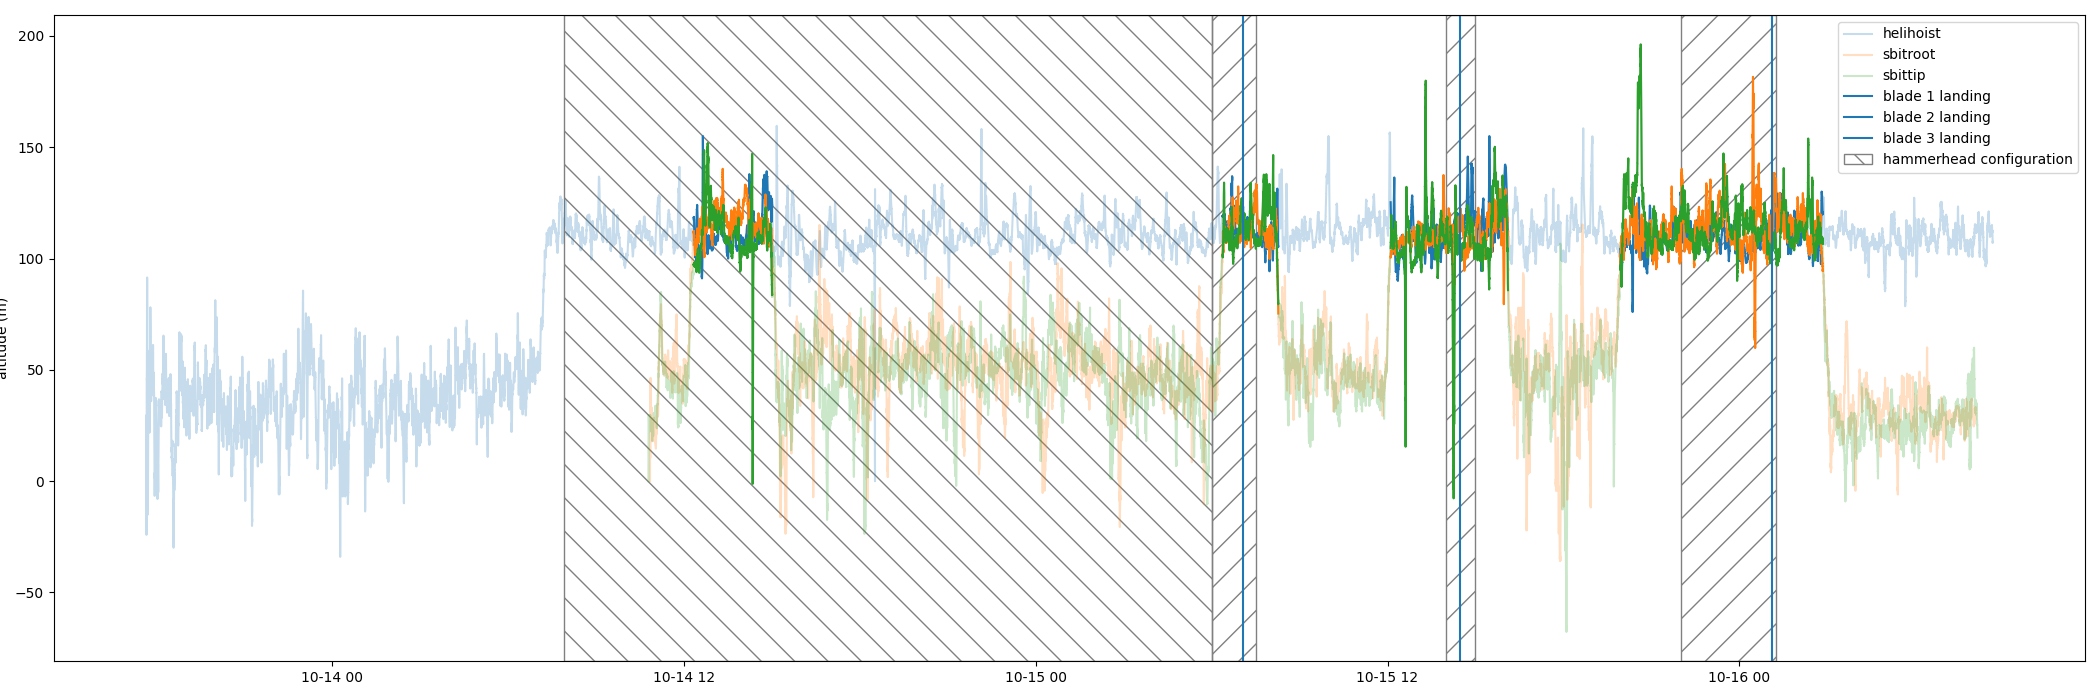

9 turbine-09
failed to identify sbi times
trying only with sbitroot
failed to identify sbi times only using sbitroot
trying only with sbittip
failed to identify sbit times only using sbittip
stopping
failed to find times for turbine-09, skipping


<IPython.core.display.Javascript object>


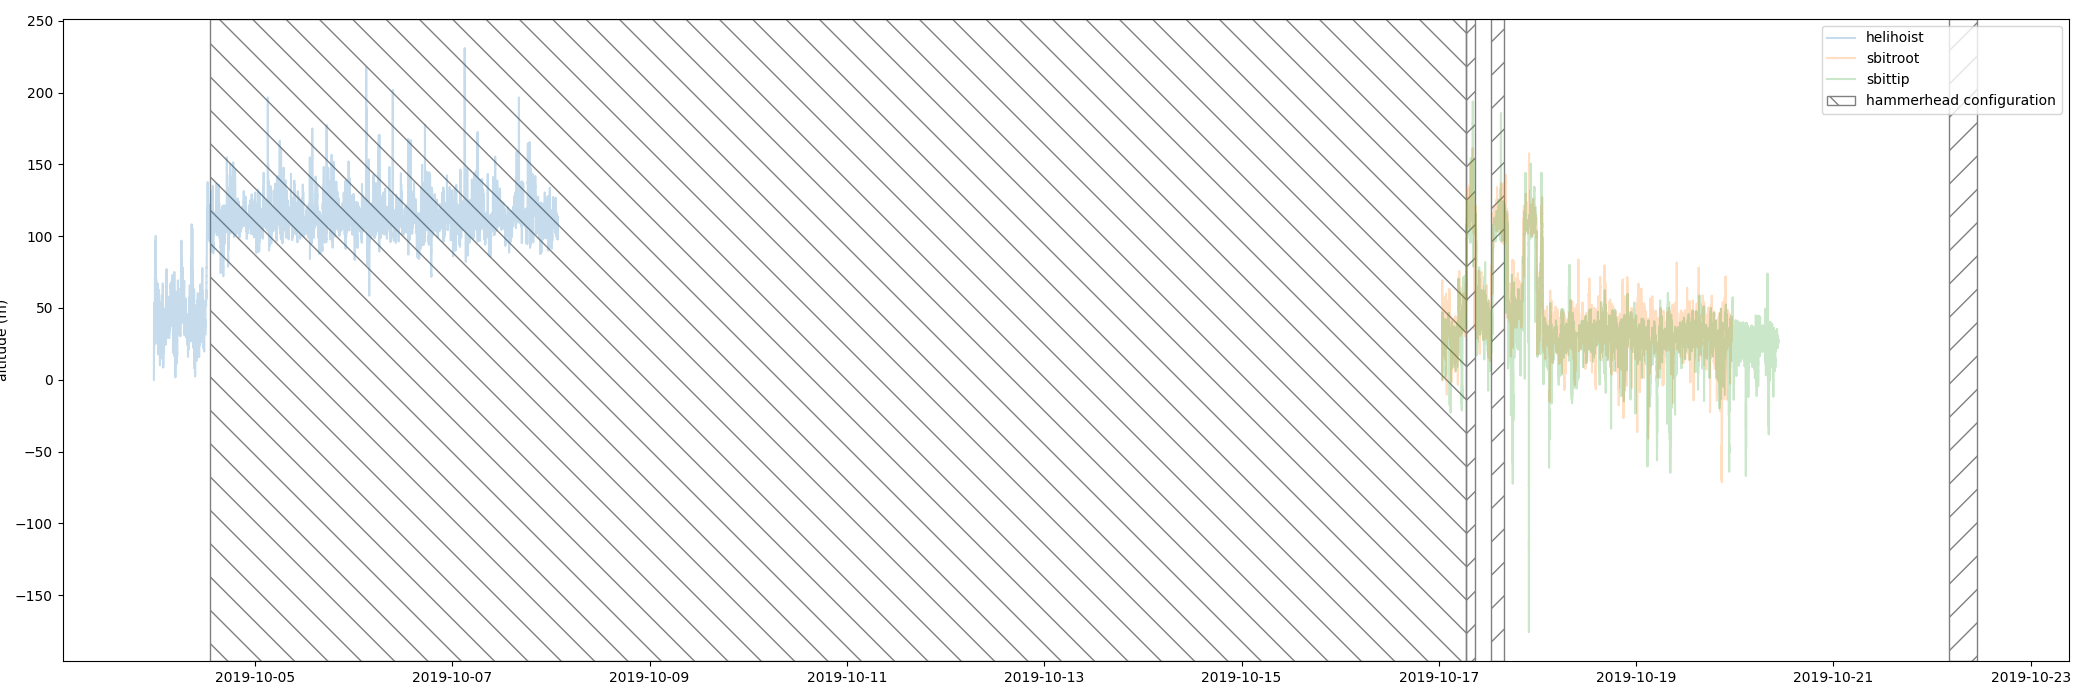

10 turbine-10


<IPython.core.display.Javascript object>


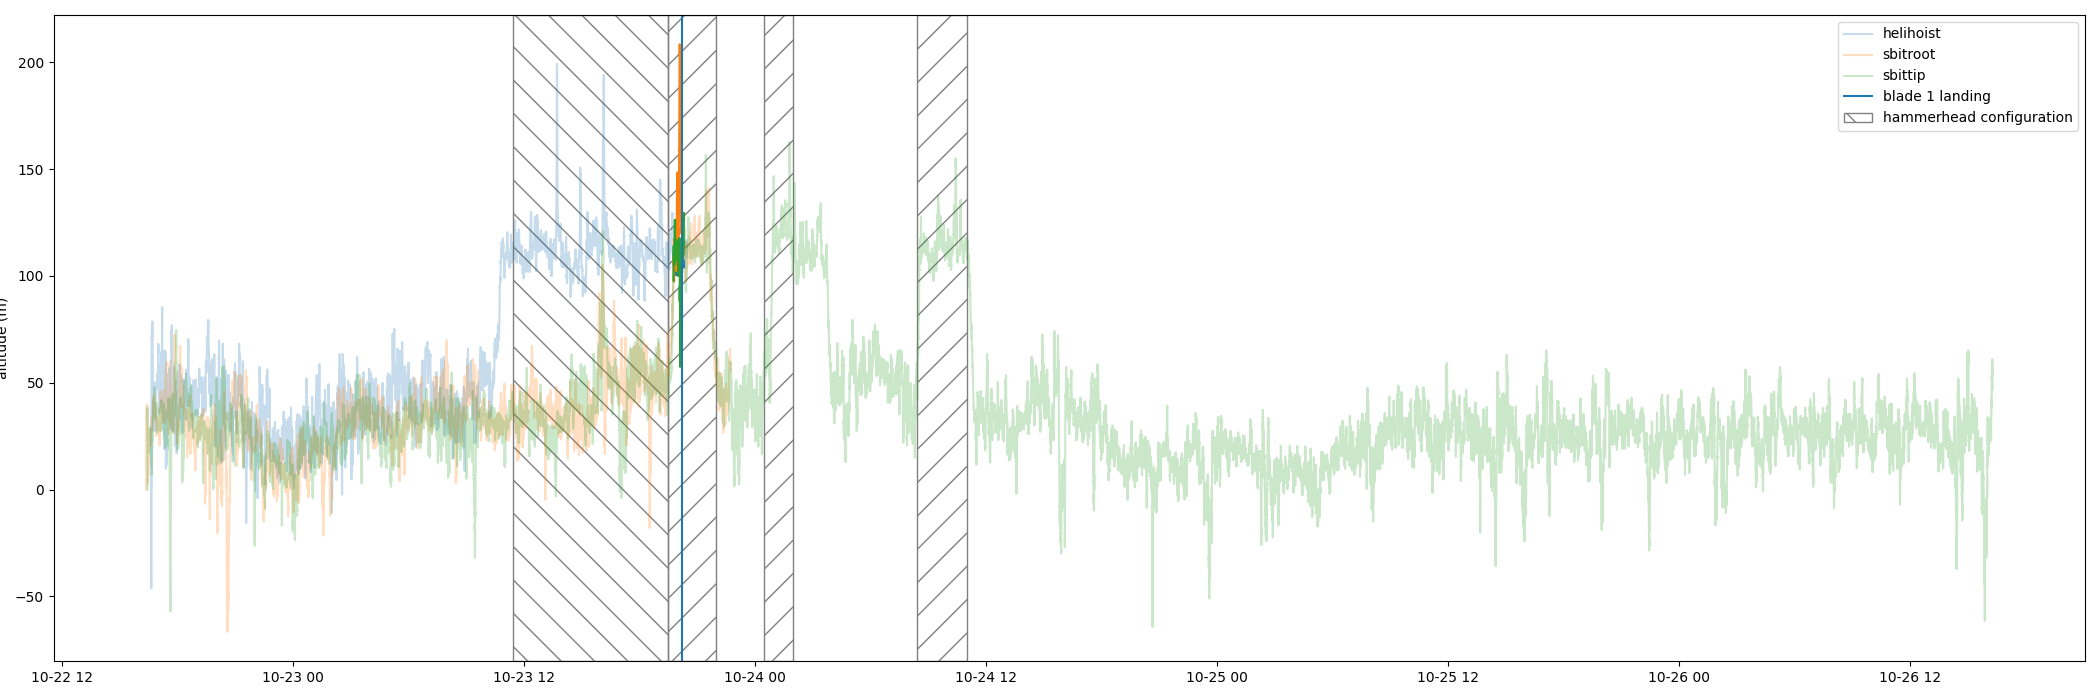

11 turbine-11


<IPython.core.display.Javascript object>


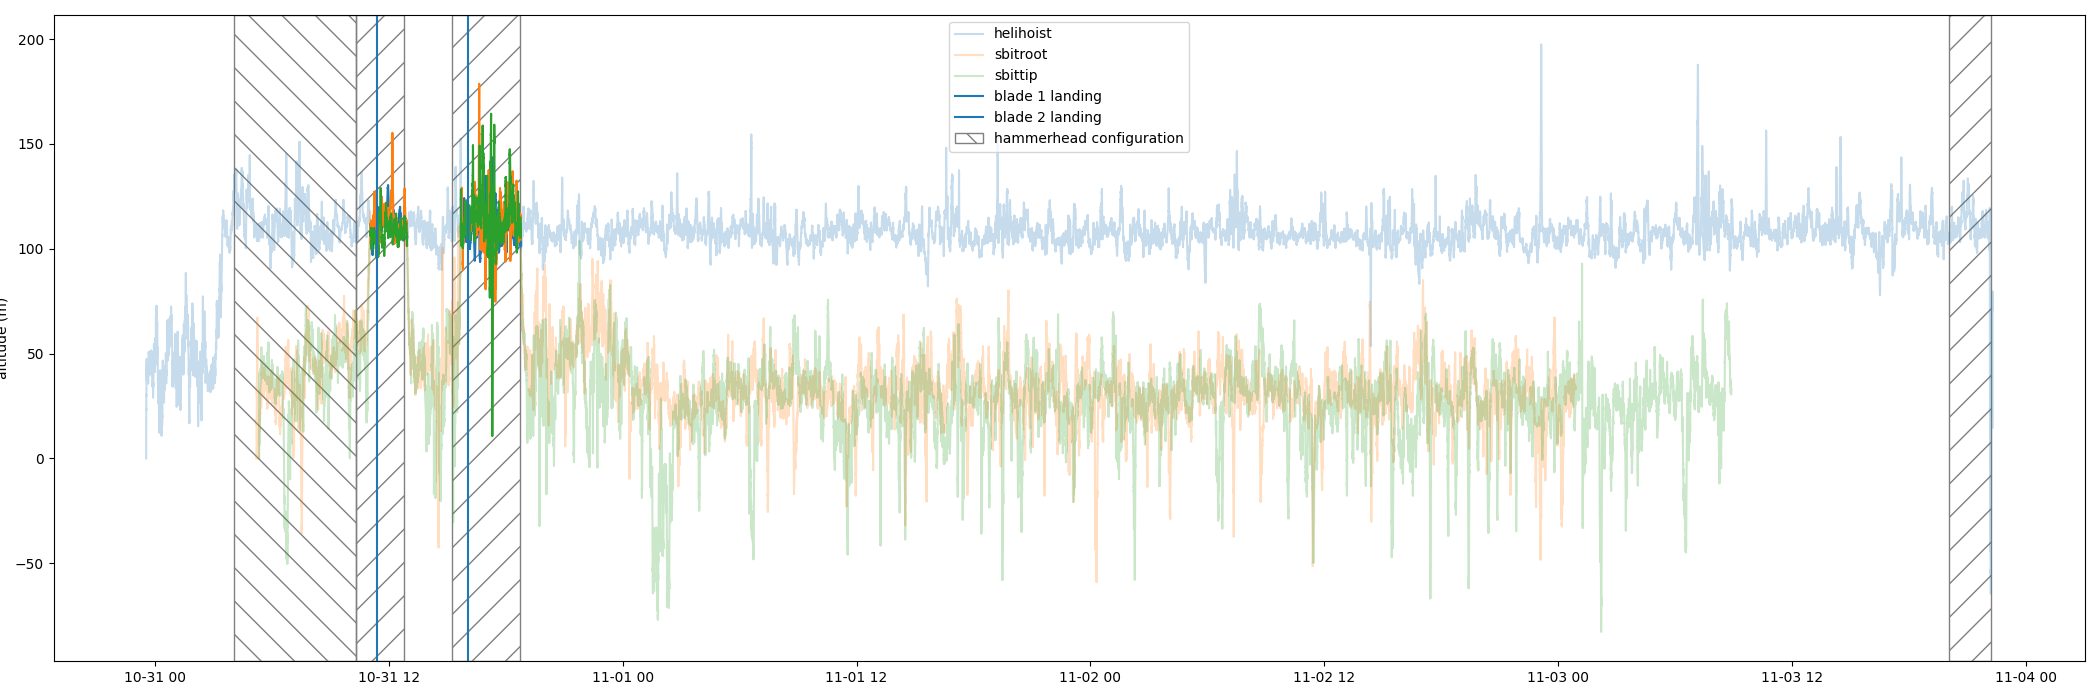

12 turbine-12


<IPython.core.display.Javascript object>


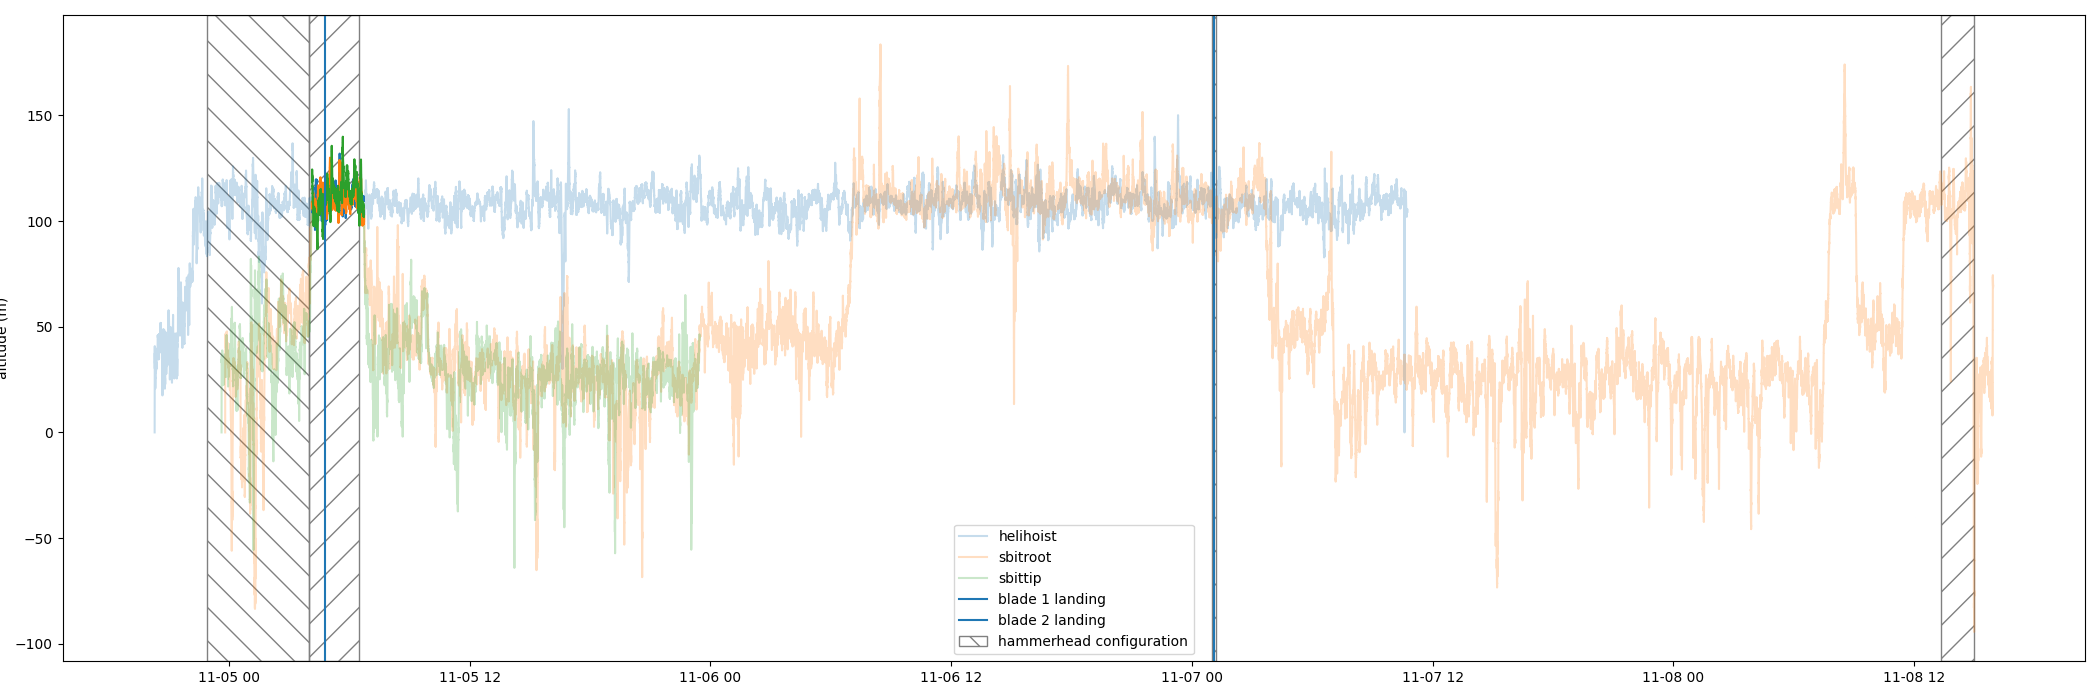

13 turbine-13
failed to identify sbi times
trying only with sbitroot


<IPython.core.display.Javascript object>


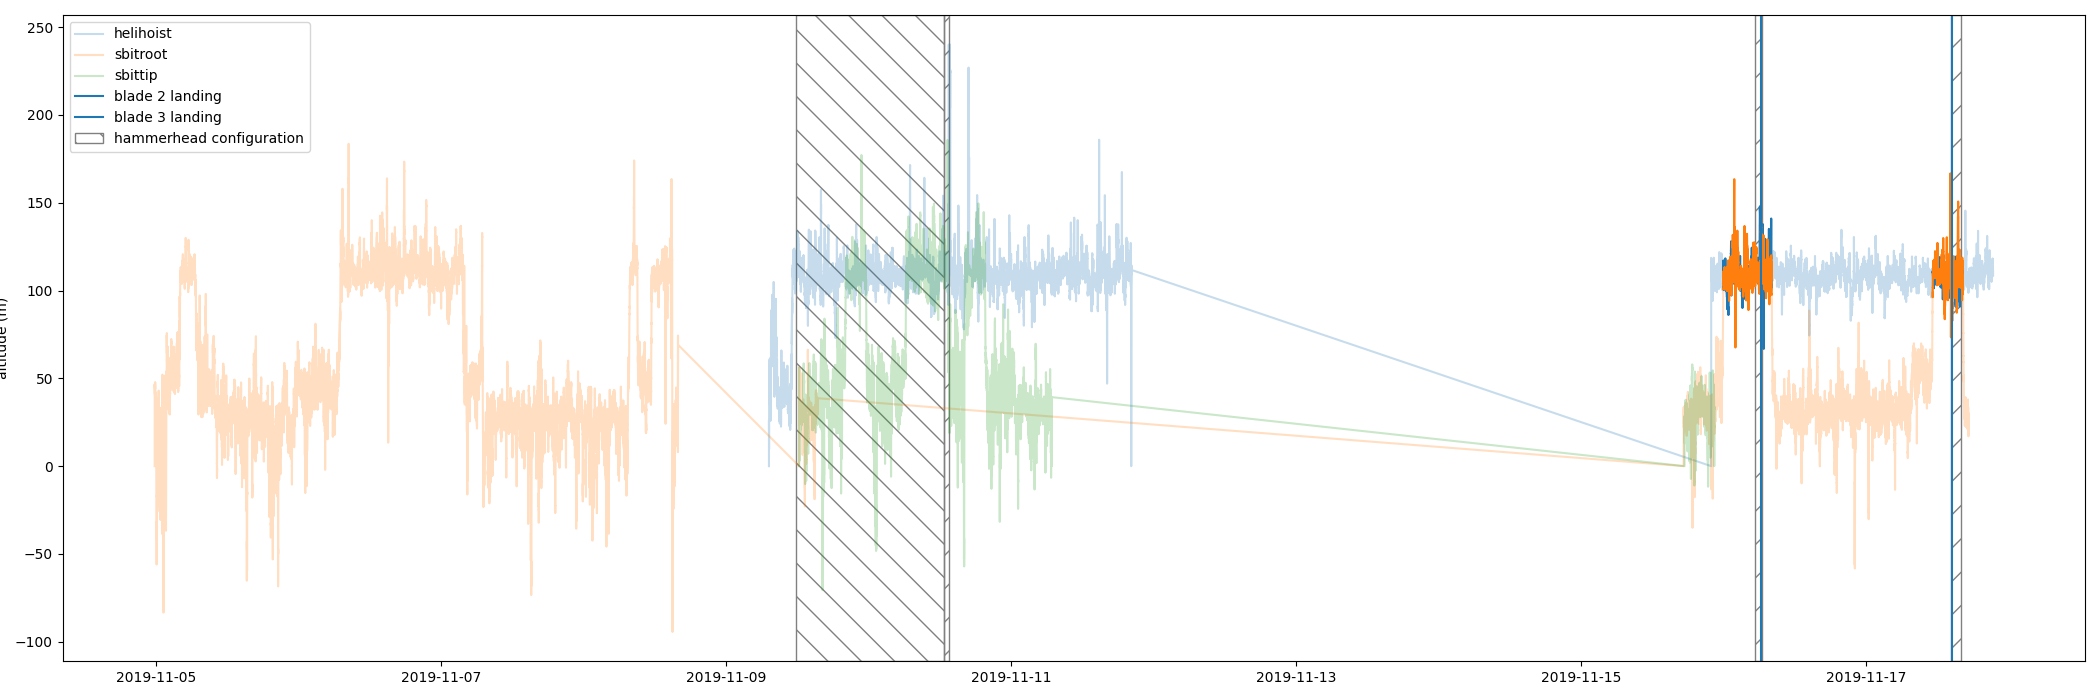

14 turbine-14


<IPython.core.display.Javascript object>


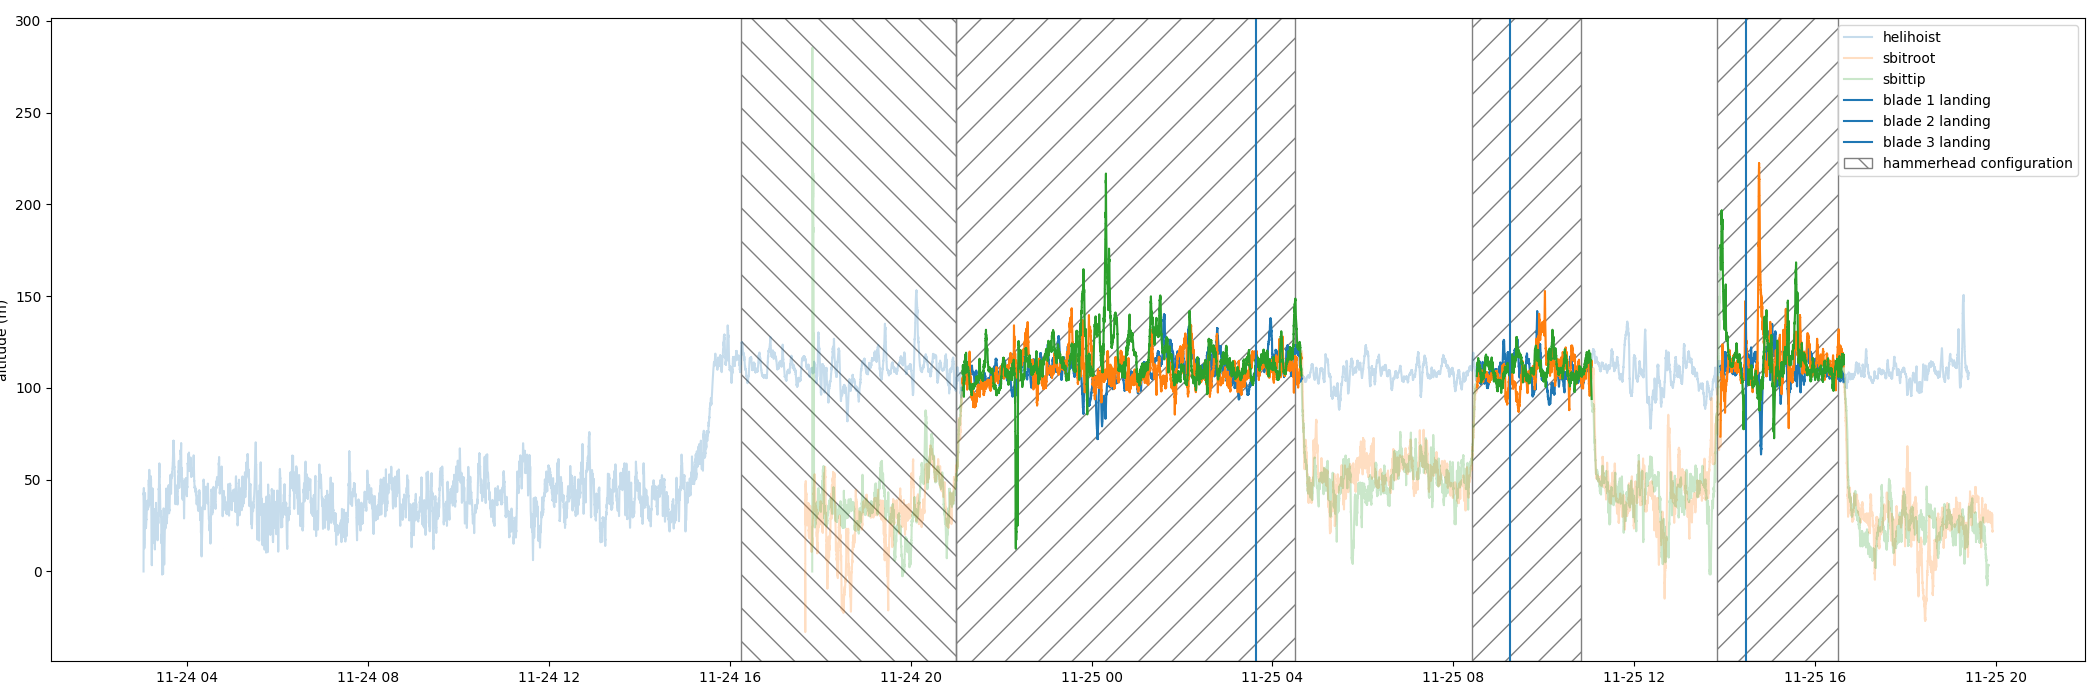

16 turbine-16
failed to identify sbi times
trying only with sbitroot
failed to identify sbi times only using sbitroot
trying only with sbittip
failed to identify sbit times only using sbittip
stopping
failed to find times for turbine-16, skipping


<IPython.core.display.Javascript object>


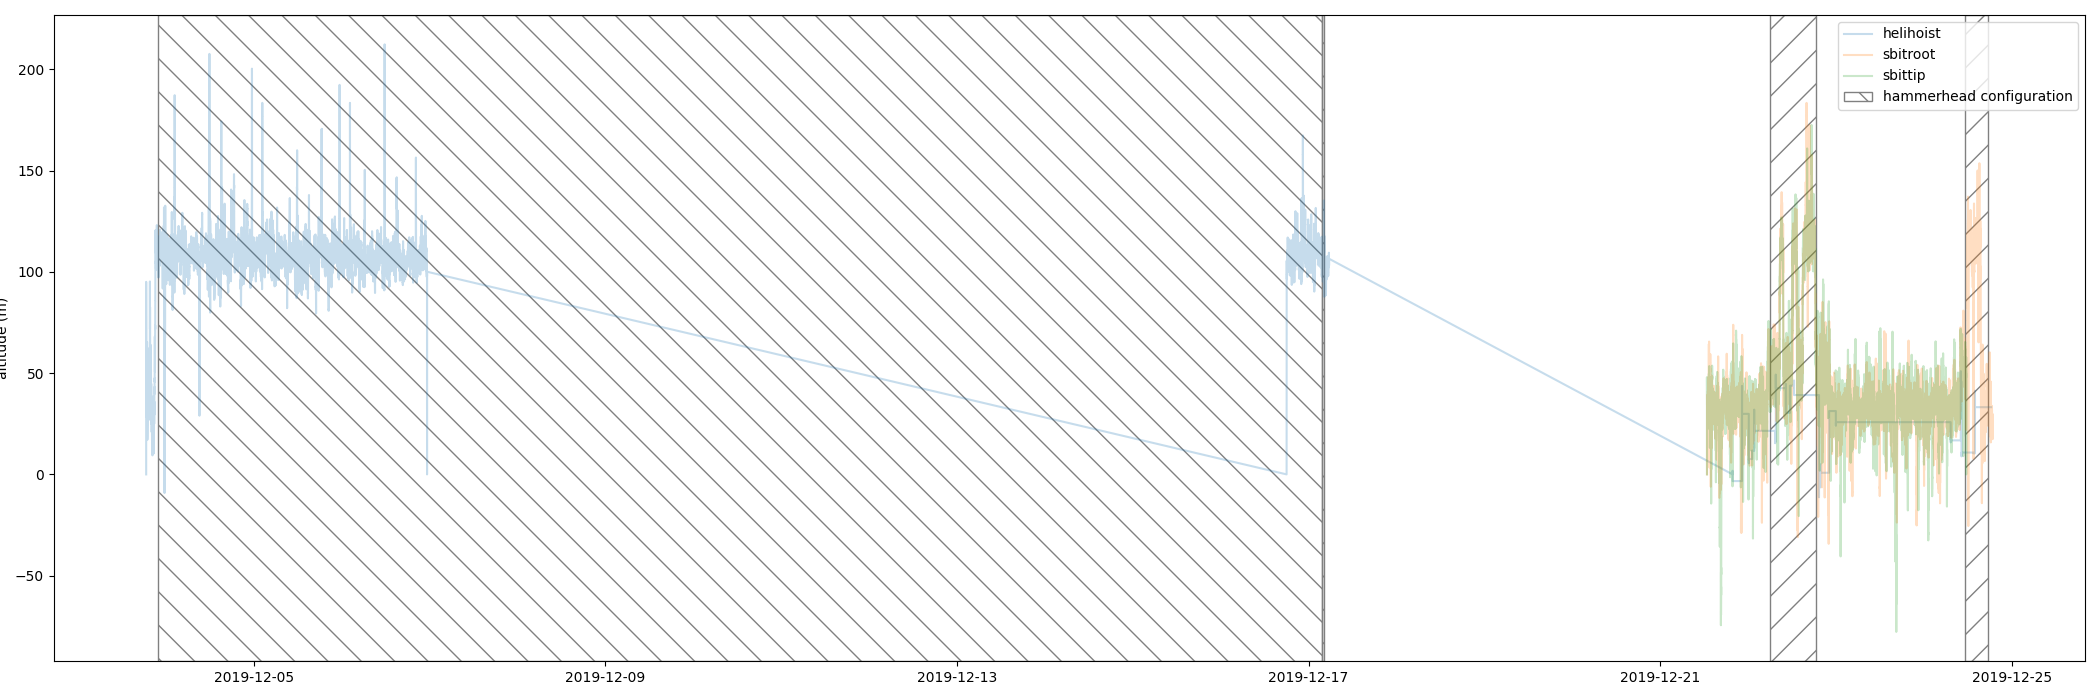

In [6]:
try:
    configuration_file = open('../data/installation_times/turbine_configurations.csv', 'w')
except Execption as e:
    print(f'failed to open file: {e}')

configuration_file.write(f'turbine_id,hammerhead_start_epoch,hammerhead_end_epoch,TNHB1_start_epoch,TNHB1_end_epoch,TNHB2_start_epoch,TNHB2_end_epoch\n')

for (turbine_name, turbine_dataset) in turbines.items():
    
    turbine_id = int(turbine_name.split('-')[-1])
    
    print(turbine_id, turbine_name)
        
    try:
        sbi_times = find_installation_times(turbine_dataset)
    except:
        print(f'failed to find times for {turbine_name}, skipping')
        
    plot_sbi_times(turbine_dataset, sbi_times, [])
    
    hammerhead_start, hammerhead_end = find_hammerhead_times(turbine_dataset, first_sbi=blade_installations[turbine_name][0][0])
    
    hammerheads[turbine_name] = (hammerhead_start, hammerhead_end)
    
    configuration_file.write(f'{turbine_name},{int(hammerhead_start.timestamp())},{int(hammerhead_end.timestamp())},{int(TNHBx[turbine_name][0][0].timestamp())},{int(TNHBx[turbine_name][0][1].timestamp())},{int(TNHBx[turbine_name][1][0].timestamp())},{int(TNHBx[turbine_name][1][1].timestamp())}\n')
    
    plt.axvspan(xmin=hammerhead_start, xmax=hammerhead_end, facecolor='None', edgecolor='grey', hatch='\\', label='hammerhead configuration')
    
    for (start, end) in blade_installations[turbine_name]:
        plt.axvspan(xmin=start, xmax=end, facecolor='None', edgecolor='grey', hatch='/')
        
    if turbine_name in blade_landings:
        for blade, blade_landing in blade_landings[turbine_name].items():
            plt.axvline(x=blade_landing, label=f'blade {blade} landing')
            
    plt.legend()
    
configuration_file.close()

### finding hammerhead data 

In [7]:
def find_files(data_dir, start, end, pattern, verbose=False, dry_run=False):
    data = list()
    
    if verbose: print(f'pattern: {pattern}')
      
    for datafile in sorted(glob(path.join(data_dir, pattern))):
        if verbose: print(f'found file: {datafile}')
        file_start, file_end = datafile.split('/')[-1].split('.')[0].split('_')[4:6]
        file_start = pd.to_datetime(file_start, format='%Y-%m-%d-%H-%M-%S', utc=True)
        file_end = pd.to_datetime(file_end, format='%Y-%m-%d-%H-%M-%S', utc=True)
        if verbose: print(f'file start: {file_start} -> file end: {file_end}')
            
        if file_start < start and file_start < end:
            if verbose: print('')
            continue
        elif file_start > start and file_start < end:
            if verbose: 
                print(f'found matching data file: {start} < {datafile} < {end}')
                print('')
            if dry_run:
                data.append(datafile)
            else:
                data.append(read_frame(datafile))
        else:
            continue
        
    if len(data) == 0:
        print('could not find matching data!')
        return pd.DataFrame()
    
    if dry_run:
        return pd.DataFrame({'files' : data})
    
    data = pd.concat(data)
    data.sort_index(inplace=True)
    
    return data

def find_data(turbine_data_dir,
              start, 
              end, 
              measurement_position=('helihoist-1', 'sbitroot', 'sbittip'),
              measurement_type='tom',
              data_type='acc-vel-pos',
              state_name='hammerhead',
              verbose=False,
              dry_run=False,
              write_data=True,
             ):

    turbine_data_dir = turbine_data_dir.rstrip('/')    
    turbine_name = turbine_data_dir.split('/')[-1]
   
    print(f'processing {turbine_name}')
    
    for pos in measurement_position:
        
        pos_dir = path.join(turbine_data_dir, pos)
        
        print(f'processing {pos_dir}')
        
        source_dir = path.join(pos_dir,
                               path.join(measurement_type,
                                         data_type
                                        )
                              )
        target_dir = path.join(source_dir, state_name)
        
        if verbose: print(f'source dir {source_dir} -> {target_dir}')
        
        data = find_files(source_dir, 
                          start, 
                          end, 
                          pattern=f'{turbine_name}_{pos}_{measurement_type}_{data_type}_*_*.csv', 
                          dry_run=dry_run,
                          verbose=verbose,
                         )
        if data.empty:
            print(f'failed to find any matching files!')
            return pd.DataFrame()
            
        if not path.isdir(target_dir):
            try:
                os.mkdir(target_dir)
            except Exception as e:
                print(f'failed to create path: {e}')
                   
        if dry_run:
            print(f'found {len(data)} files for {turbine_name}_{pos}_{measurement_type}_{data_type}')
            return
        
        record_start = data.index[0].strftime('%Y-%m-%d-%H-%M-%S')
        record_end = data.index[-1].strftime('%Y-%m-%d-%H-%M-%S')
        
        if verbose: print(f'configuration {state_name}: record spans {record_start} -> {record_end}')
        
        outfile_name = f'{turbine_name}_{pos}_{measurement_type}_{data_type}_{state_name}_{record_start}_{record_end}.csv'
        
        if verbose: print(f'output data file name: {outfile_name}')
        
        outfile_path = path.join(target_dir, outfile_name)
        
        print(f'output data file path: {outfile_path}')
    
        if write_data:
            if verbose: print('exporting data')
            write_frame(data, outfile_path)     
        
        

In [8]:
find_data(turbine_data_dir='../data/turbines/turbine-08/', 
          start=hammerheads['turbine-08'][0],
          end=hammerheads['turbine-08'][1],
          dry_run=False,
          verbose=True,
          write_data=False,
         )

processing turbine-08
processing ../data/turbines/turbine-08/helihoist-1
source dir ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos -> ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/hammerhead
pattern: turbine-08_helihoist-1_tom_acc-vel-pos_*_*.csv
found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-13-17-36-38_2019-10-13-18-03-31.csv
file start: 2019-10-13 17:36:38+00:00 -> file end: 2019-10-13 18:03:31+00:00

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-13-18-03-31_2019-10-13-18-30-16.csv
file start: 2019-10-13 18:03:31+00:00 -> file end: 2019-10-13 18:30:16+00:00

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-13-18-30-16_2019-10-13-18-57-04.csv
file start: 2019-10-13 18:30:16+00:00 -> file end: 2019-10-13 18:57:04+00:00

found file: ../data/turbines/turbine-08/helihoi

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-08-22-37_2019-10-14-08-48-41.csv
file start: 2019-10-14 08:22:37+00:00 -> file end: 2019-10-14 08:48:41+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-08-22-37_2019-10-14-08-48-41.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-08-48-41_2019-10-14-09-13-49.csv
file start: 2019-10-14 08:48:41+00:00 -> file end: 2019-10-14 09:13:49+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-08-48-41_2019-10-14-09-13-49.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-v

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-16-29-55_2019-10-14-16-56-41.csv
file start: 2019-10-14 16:29:55+00:00 -> file end: 2019-10-14 16:56:41+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-16-29-55_2019-10-14-16-56-41.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-16-56-41_2019-10-14-17-23-27.csv
file start: 2019-10-14 16:56:41+00:00 -> file end: 2019-10-14 17:23:27+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-14-16-56-41_2019-10-14-17-23-27.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-v

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-00-31-47_2019-10-15-00-57-02.csv
file start: 2019-10-15 00:31:47+00:00 -> file end: 2019-10-15 00:57:02+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-00-31-47_2019-10-15-00-57-02.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-00-57-02_2019-10-15-01-22-15.csv
file start: 2019-10-15 00:57:02+00:00 -> file end: 2019-10-15 01:22:15+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-vel-pos_2019-10-15-00-57-02_2019-10-15-01-22-15.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/turbine-08_helihoist-1_tom_acc-v

found file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-11-18-37_2019-10-14-11-47-40.csv
file start: 2019-10-14 11:18:37+00:00 -> file end: 2019-10-14 11:47:40+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-11-18-37_2019-10-14-11-47-40.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-11-47-40_2019-10-14-12-16-47.csv
file start: 2019-10-14 11:47:40+00:00 -> file end: 2019-10-14 12:16:47+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-11-47-40_2019-10-14-12-16-47.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-12-16-47_201

found file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-20-06-06_2019-10-14-20-33-47.csv
file start: 2019-10-14 20:06:06+00:00 -> file end: 2019-10-14 20:33:47+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-20-06-06_2019-10-14-20-33-47.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-20-33-48_2019-10-14-21-01-29.csv
file start: 2019-10-14 20:33:48+00:00 -> file end: 2019-10-14 21:01:29+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-20-33-48_2019-10-14-21-01-29.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-14-21-01-29_201

found file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-15-04-56-11_2019-10-15-05-23-43.csv
file start: 2019-10-15 04:56:11+00:00 -> file end: 2019-10-15 05:23:43+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-15-04-56-11_2019-10-15-05-23-43.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-15-05-23-43_2019-10-15-05-51-16.csv
file start: 2019-10-15 05:23:43+00:00 -> file end: 2019-10-15 05:51:16+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-15-05-23-43_2019-10-15-05-51-16.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/turbine-08_sbitroot_tom_acc-vel-pos_2019-10-15-05-51-16_201

found file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-11-13-23_2019-10-14-11-40-34.csv
file start: 2019-10-14 11:13:23+00:00 -> file end: 2019-10-14 11:40:34+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-11-13-23_2019-10-14-11-40-34.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-11-40-34_2019-10-14-12-07-43.csv
file start: 2019-10-14 11:40:34+00:00 -> file end: 2019-10-14 12:07:43+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-11-40-34_2019-10-14-12-07-43.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-12-07-44_2019-10-14-12

found file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-19-34-42_2019-10-14-20-01-32.csv
file start: 2019-10-14 19:34:42+00:00 -> file end: 2019-10-14 20:01:32+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-19-34-42_2019-10-14-20-01-32.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-20-01-33_2019-10-14-20-28-23.csv
file start: 2019-10-14 20:01:33+00:00 -> file end: 2019-10-14 20:28:23+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-20-01-33_2019-10-14-20-28-23.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-14-20-28-23_2019-10-14-20

found file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-15-03-58-44_2019-10-15-04-24-17.csv
file start: 2019-10-15 03:58:44+00:00 -> file end: 2019-10-15 04:24:17+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-15-03-58-44_2019-10-15-04-24-17.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-15-04-24-17_2019-10-15-04-49-53.csv
file start: 2019-10-15 04:24:17+00:00 -> file end: 2019-10-15 04:49:53+00:00
found matching data file: 2019-10-14 07:55:28+00:00 < ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-15-04-24-17_2019-10-15-04-49-53.csv < 2019-10-15 06:00:00+00:00

found file: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/turbine-08_sbittip_tom_acc-vel-pos_2019-10-15-04-49-53_2019-10-15-05

In [10]:
for turbine_path in sorted(glob(path.join(turbine_data_dir, f'turbine-??'))):
    
    turbine_name = turbine_path.split('/')[3]
   
    if turbine_name not in selected_turbines:
        print(f'skipping {turbine_name}')
        continue

    print(f'processing {turbine_name}')
    
    # do the hammerhead
    find_data(turbine_data_dir=turbine_path,
              start=hammerheads[turbine_name][0],
              end=hammerheads[turbine_name][1],
              state_name='hammerhead',
             )
    # different installation stages
    for i, (start, end) in enumerate(blade_installations[turbine_name]):
        print(f'blade installation {i+1}: {start} -> {end}')
        find_data(turbine_data_dir=turbine_path,
                  start=start,
                  end=end,
                  state_name=f'sbi{i+1}',
                 )
    for i, (start, end) in enumerate(TNHBx[turbine_name]):
        print(f'TNHB{i+1}: {start} -> {end}')
        find_data(turbine_data_dir=turbine_path,
                  start=start,
                  end=end,
                  state_name=f'tnhb{i+1}',
                 )
    printMD('---')

skipping turbine-01
skipping turbine-02
skipping turbine-03
processing turbine-04
processing turbine-04
processing ../data/turbines/turbine-04/helihoist-1
output data file path: ../data/turbines/turbine-04/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-04_helihoist-1_tom_acc-vel-pos_hammerhead_2019-09-01-10-20-45_2019-09-07-07-19-26.csv
processing ../data/turbines/turbine-04/sbitroot
output data file path: ../data/turbines/turbine-04/sbitroot/tom/acc-vel-pos/hammerhead/turbine-04_sbitroot_tom_acc-vel-pos_hammerhead_2019-09-07-04-48-53_2019-09-07-07-12-46.csv
processing ../data/turbines/turbine-04/sbittip
output data file path: ../data/turbines/turbine-04/sbittip/tom/acc-vel-pos/hammerhead/turbine-04_sbittip_tom_acc-vel-pos_hammerhead_2019-09-07-04-41-36_2019-09-07-07-25-10.csv
blade installation 1: 2019-09-07 07:00:00+00:00 -> 2019-09-07 12:30:00+00:00
processing turbine-04
processing ../data/turbines/turbine-04/helihoist-1
output data file path: ../data/turbines/turbine-04/helihoist-1

---

processing turbine-05
processing turbine-05
processing ../data/turbines/turbine-05/helihoist-1
output data file path: ../data/turbines/turbine-05/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-05_helihoist-1_tom_acc-vel-pos_hammerhead_2019-09-10-16-04-47_2019-09-20-02-53-43.csv
processing ../data/turbines/turbine-05/sbitroot
output data file path: ../data/turbines/turbine-05/sbitroot/tom/acc-vel-pos/hammerhead/turbine-05_sbitroot_tom_acc-vel-pos_hammerhead_2019-09-19-17-29-33_2019-09-20-02-34-11.csv
processing ../data/turbines/turbine-05/sbittip
output data file path: ../data/turbines/turbine-05/sbittip/tom/acc-vel-pos/hammerhead/turbine-05_sbittip_tom_acc-vel-pos_hammerhead_2019-09-19-17-22-03_2019-09-20-02-47-05.csv
blade installation 1: 2019-09-20 02:30:00+00:00 -> 2019-09-20 07:17:00+00:00
processing turbine-05
processing ../data/turbines/turbine-05/helihoist-1
output data file path: ../data/turbines/turbine-05/helihoist-1/tom/acc-vel-pos/sbi1/turbine-05_helihoist-1_tom_acc-vel-pos

---

processing turbine-06
processing turbine-06
processing ../data/turbines/turbine-06/helihoist-1
output data file path: ../data/turbines/turbine-06/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-06_helihoist-1_tom_acc-vel-pos_hammerhead_2019-09-22-03-14-43_2019-09-22-12-05-47.csv
processing ../data/turbines/turbine-06/sbitroot
output data file path: ../data/turbines/turbine-06/sbitroot/tom/acc-vel-pos/hammerhead/turbine-06_sbitroot_tom_acc-vel-pos_hammerhead_2019-09-22-03-11-49_2019-09-22-12-15-43.csv
processing ../data/turbines/turbine-06/sbittip
output data file path: ../data/turbines/turbine-06/sbittip/tom/acc-vel-pos/hammerhead/turbine-06_sbittip_tom_acc-vel-pos_hammerhead_2019-09-22-03-16-30_2019-09-22-12-12-21.csv
blade installation 1: 2019-09-22 11:50:00+00:00 -> 2019-09-22 12:23:00+00:00
processing turbine-06
processing ../data/turbines/turbine-06/helihoist-1
output data file path: ../data/turbines/turbine-06/helihoist-1/tom/acc-vel-pos/sbi1/turbine-06_helihoist-1_tom_acc-vel-pos

---

processing turbine-07
processing turbine-07
processing ../data/turbines/turbine-07/helihoist-1
output data file path: ../data/turbines/turbine-07/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-07_helihoist-1_tom_acc-vel-pos_hammerhead_2019-09-24-11-38-50_2019-09-25-12-01-27.csv
processing ../data/turbines/turbine-07/sbitroot
output data file path: ../data/turbines/turbine-07/sbitroot/tom/acc-vel-pos/hammerhead/turbine-07_sbitroot_tom_acc-vel-pos_hammerhead_2019-09-24-11-56-08_2019-09-25-11-58-23.csv
processing ../data/turbines/turbine-07/sbittip
output data file path: ../data/turbines/turbine-07/sbittip/tom/acc-vel-pos/hammerhead/turbine-07_sbittip_tom_acc-vel-pos_hammerhead_2019-09-24-11-59-00_2019-09-25-00-25-15.csv
blade installation 1: 2019-09-25 11:45:00+00:00 -> 2019-09-25 13:45:00+00:00
processing turbine-07
processing ../data/turbines/turbine-07/helihoist-1
output data file path: ../data/turbines/turbine-07/helihoist-1/tom/acc-vel-pos/sbi1/turbine-07_helihoist-1_tom_acc-vel-pos

---

processing turbine-08
processing turbine-08
processing ../data/turbines/turbine-08/helihoist-1
output data file path: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-08_helihoist-1_tom_acc-vel-pos_hammerhead_2019-10-14-07-55-52_2019-10-15-06-10-33.csv
processing ../data/turbines/turbine-08/sbitroot
output data file path: ../data/turbines/turbine-08/sbitroot/tom/acc-vel-pos/hammerhead/turbine-08_sbitroot_tom_acc-vel-pos_hammerhead_2019-10-14-10-49-53_2019-10-15-06-18-48.csv
processing ../data/turbines/turbine-08/sbittip
output data file path: ../data/turbines/turbine-08/sbittip/tom/acc-vel-pos/hammerhead/turbine-08_sbittip_tom_acc-vel-pos_hammerhead_2019-10-14-10-45-39_2019-10-15-06-08-27.csv
blade installation 1: 2019-10-15 06:00:00+00:00 -> 2019-10-15 07:30:00+00:00
processing turbine-08
processing ../data/turbines/turbine-08/helihoist-1
output data file path: ../data/turbines/turbine-08/helihoist-1/tom/acc-vel-pos/sbi1/turbine-08_helihoist-1_tom_acc-vel-pos

---

processing turbine-09
processing turbine-09
processing ../data/turbines/turbine-09/helihoist-1
output data file path: ../data/turbines/turbine-09/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-09_helihoist-1_tom_acc-vel-pos_hammerhead_2019-10-04-12-59-44_2019-10-08-01-41-05.csv
processing ../data/turbines/turbine-09/sbitroot
output data file path: ../data/turbines/turbine-09/sbitroot/tom/acc-vel-pos/hammerhead/turbine-09_sbitroot_tom_acc-vel-pos_hammerhead_2019-10-17-00-43-06_2019-10-17-06-47-39.csv
processing ../data/turbines/turbine-09/sbittip
output data file path: ../data/turbines/turbine-09/sbittip/tom/acc-vel-pos/hammerhead/turbine-09_sbittip_tom_acc-vel-pos_hammerhead_2019-10-17-00-50-54_2019-10-17-06-49-19.csv
blade installation 1: 2019-10-17 06:30:00+00:00 -> 2019-10-17 08:45:00+00:00
processing turbine-09
processing ../data/turbines/turbine-09/helihoist-1
could not find matching data!
failed to find any matching files!
blade installation 2: 2019-10-17 12:45:00+00:00 -> 2019-1

---

processing turbine-10
processing turbine-10
processing ../data/turbines/turbine-10/helihoist-1
output data file path: ../data/turbines/turbine-10/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-10_helihoist-1_tom_acc-vel-pos_hammerhead_2019-10-23-11-32-59_2019-10-23-19-42-22.csv
processing ../data/turbines/turbine-10/sbitroot
output data file path: ../data/turbines/turbine-10/sbitroot/tom/acc-vel-pos/hammerhead/turbine-10_sbitroot_tom_acc-vel-pos_hammerhead_2019-10-23-11-48-51_2019-10-23-19-45-30.csv
processing ../data/turbines/turbine-10/sbittip
output data file path: ../data/turbines/turbine-10/sbittip/tom/acc-vel-pos/hammerhead/turbine-10_sbittip_tom_acc-vel-pos_hammerhead_2019-10-23-11-40-32_2019-10-23-19-55-12.csv
blade installation 1: 2019-10-23 19:30:00+00:00 -> 2019-10-23 22:00:00+00:00
processing turbine-10
processing ../data/turbines/turbine-10/helihoist-1
output data file path: ../data/turbines/turbine-10/helihoist-1/tom/acc-vel-pos/sbi1/turbine-10_helihoist-1_tom_acc-vel-pos

---

processing turbine-11
processing turbine-11
processing ../data/turbines/turbine-11/helihoist-1
output data file path: ../data/turbines/turbine-11/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-11_helihoist-1_tom_acc-vel-pos_hammerhead_2019-10-31-04-18-02_2019-10-31-10-41-13.csv
processing ../data/turbines/turbine-11/sbitroot
output data file path: ../data/turbines/turbine-11/sbitroot/tom/acc-vel-pos/hammerhead/turbine-11_sbitroot_tom_acc-vel-pos_hammerhead_2019-10-31-05-10-55_2019-10-31-10-38-59.csv
processing ../data/turbines/turbine-11/sbittip
output data file path: ../data/turbines/turbine-11/sbittip/tom/acc-vel-pos/hammerhead/turbine-11_sbittip_tom_acc-vel-pos_hammerhead_2019-10-31-05-17-56_2019-10-31-10-23-54.csv
blade installation 1: 2019-10-31 10:20:00+00:00 -> 2019-10-31 12:45:00+00:00
processing turbine-11
processing ../data/turbines/turbine-11/helihoist-1
output data file path: ../data/turbines/turbine-11/helihoist-1/tom/acc-vel-pos/sbi1/turbine-11_helihoist-1_tom_acc-vel-pos

---

processing turbine-12
processing turbine-12
processing ../data/turbines/turbine-12/helihoist-1
output data file path: ../data/turbines/turbine-12/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-12_helihoist-1_tom_acc-vel-pos_hammerhead_2019-11-04-23-16-25_2019-11-05-04-33-05.csv
processing ../data/turbines/turbine-12/sbitroot
output data file path: ../data/turbines/turbine-12/sbitroot/tom/acc-vel-pos/hammerhead/turbine-12_sbitroot_tom_acc-vel-pos_hammerhead_2019-11-04-23-44-46_2019-11-05-04-18-04.csv
processing ../data/turbines/turbine-12/sbittip
output data file path: ../data/turbines/turbine-12/sbittip/tom/acc-vel-pos/hammerhead/turbine-12_sbittip_tom_acc-vel-pos_hammerhead_2019-11-04-23-35-05_2019-11-05-04-11-07.csv
blade installation 1: 2019-11-05 04:00:00+00:00 -> 2019-11-05 06:30:00+00:00
processing turbine-12
processing ../data/turbines/turbine-12/helihoist-1
output data file path: ../data/turbines/turbine-12/helihoist-1/tom/acc-vel-pos/sbi1/turbine-12_helihoist-1_tom_acc-vel-pos

---

processing turbine-13
processing turbine-13
processing ../data/turbines/turbine-13/helihoist-1
output data file path: ../data/turbines/turbine-13/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-13_helihoist-1_tom_acc-vel-pos_hammerhead_2019-11-09-12-22-51_2019-11-10-12-59-19.csv
processing ../data/turbines/turbine-13/sbitroot
output data file path: ../data/turbines/turbine-13/sbitroot/tom/acc-vel-pos/hammerhead/turbine-13_sbitroot_tom_acc-vel-pos_hammerhead_2019-11-09-12-12-04_2019-11-09-15-25-59.csv
processing ../data/turbines/turbine-13/sbittip
output data file path: ../data/turbines/turbine-13/sbittip/tom/acc-vel-pos/hammerhead/turbine-13_sbittip_tom_acc-vel-pos_hammerhead_2019-11-09-12-13-17_2019-11-10-13-04-29.csv
blade installation 1: 2019-11-10 12:45:00+00:00 -> 2019-11-10 13:30:00+00:00
processing turbine-13
processing ../data/turbines/turbine-13/helihoist-1
output data file path: ../data/turbines/turbine-13/helihoist-1/tom/acc-vel-pos/sbi1/turbine-13_helihoist-1_tom_acc-vel-pos

---

processing turbine-14
processing turbine-14
processing ../data/turbines/turbine-14/helihoist-1
output data file path: ../data/turbines/turbine-14/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-14_helihoist-1_tom_acc-vel-pos_hammerhead_2019-11-24-16-42-08_2019-11-24-21-16-51.csv
processing ../data/turbines/turbine-14/sbitroot
output data file path: ../data/turbines/turbine-14/sbitroot/tom/acc-vel-pos/hammerhead/turbine-14_sbitroot_tom_acc-vel-pos_hammerhead_2019-11-24-17-36-41_2019-11-24-21-15-48.csv
processing ../data/turbines/turbine-14/sbittip
output data file path: ../data/turbines/turbine-14/sbittip/tom/acc-vel-pos/hammerhead/turbine-14_sbittip_tom_acc-vel-pos_hammerhead_2019-11-24-17-46-36_2019-11-24-21-21-03.csv
blade installation 1: 2019-11-24 21:00:00+00:00 -> 2019-11-25 04:30:00+00:00
processing turbine-14
processing ../data/turbines/turbine-14/helihoist-1
output data file path: ../data/turbines/turbine-14/helihoist-1/tom/acc-vel-pos/sbi1/turbine-14_helihoist-1_tom_acc-vel-pos

---

skipping turbine-15
processing turbine-16
processing turbine-16
processing ../data/turbines/turbine-16/helihoist-1
output data file path: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/hammerhead/turbine-16_helihoist-1_tom_acc-vel-pos_hammerhead_2019-12-03-22-07-33_2019-12-17-03-56-11.csv
processing ../data/turbines/turbine-16/sbitroot
could not find matching data!
failed to find any matching files!
blade installation 1: 2019-12-17 03:45:00+00:00 -> 2019-12-17 04:15:00+00:00
processing turbine-16
processing ../data/turbines/turbine-16/helihoist-1
output data file path: ../data/turbines/turbine-16/helihoist-1/tom/acc-vel-pos/sbi1/turbine-16_helihoist-1_tom_acc-vel-pos_sbi1_2019-12-17-03-56-11_2019-12-17-04-22-54.csv
processing ../data/turbines/turbine-16/sbitroot
could not find matching data!
failed to find any matching files!
blade installation 2: 2019-12-22 06:00:00+00:00 -> 2019-12-22 18:30:00+00:00
processing turbine-16
processing ../data/turbines/turbine-16/helihoist-1
out

---